In [2022]:
import numpy as np 
import matplotlib.pyplot as plt

In [2023]:
def norma(arr): 
    return np.linalg.norm(arr)

In [2024]:
f_calls = 0

def f(x):
    global f_calls
    f_calls += 1
    return (10 * (x[0] - x[1]) ** 2 + (x[0] - 1) ** 2) ** (1/4)
    # return 100 * (x[0]**2 - x[1])**2 + (x[0]-1)**2
    # return (10 * (x[0] - x[1])**2 + (x[0]-1)**2)**4

In [2025]:
def gradient(x, h, diff_scheme):
    if diff_scheme == "center":
        return np.array([(f(np.array([x[0] + h, x[1]])) - f(np.array([x[0] - h, x[1]]))) / (2 * h), (f(np.array([x[0], x[1] + h])) - f(np.array([x[0], x[1] - h]))) / (2 * h)])
    elif diff_scheme == "right":
        return np.array([(f(np.array([x[0] + h, x[1]])) - f(x)) / h, (f(np.array([x[0], x[1] + h])) - f(x)) / h])
    elif diff_scheme == "left":
        return np.array([(f(x) - f(np.array([x[0] - h, x[1]]))) / h, (f(x) - f(np.array([x[0], x[1] - h]))) / h])

In [2026]:
def first_termination_criterion(x1, x2, e):
    return ((norma(x1-x2)/norma(x2)) <= e) & (abs(f(x1)-f(x2))/abs(f(x2)) <= e)

def second_termination_criterion(x, h, diff_scheme, e):
    return norma(gradient(x, h, diff_scheme)) <= e

In [2027]:
def DSK_Powell_method(f, a, b, e):
    xs = np.array([a, (a + b) / 2, b])
    dx = (b - a) / 2
    fx = [f(x) for x in xs]

    x_star = xs[1] + dx * (fx[0] - fx[2]) / (2 * (fx[0] - 2 * fx[1] + fx[2]))
    
    def end_check(x2, x_star):
        df, dx = f(x2) - f(x_star), x2 - x_star

        first_check = np.abs(df) <= e
        second_check = np.abs(dx) <= e

        return first_check and second_check

    while not end_check(xs[1], x_star):
        xs = np.append(xs, x_star)
        xs.sort()
        fxs = np.array([f(x) for x in xs])
        id_min = np.argmin(fxs)

        if id_min == 0:
            xs = xs[:3]
        elif id_min == len(xs) - 1:
            xs = xs[-3:]
        else:
            xs = xs[id_min - 1: id_min + 2]

        xs = np.unique(xs)
        if len(xs) < 3:
            print("Помилка: масив xs не містить трьох унікальних елементів")
            break
        

        x1, x2, x3 = xs
        a1 = (f(x2) - f(x1)) / (x2 - x1)
        a2 = 1 / (x3 - x2) * ((f(x3) - f(x1)) / (x3 - x1) - (f(x2) - f(x1)) / (x2 - x1))
        x_star = (x1 + x2) / 2 - a1 / 2 / a2

    return x_star

def DSK_Powell_method_n(a, b, x0, s, e, f):
  f_new = lambda l: f(x0 + l * s)
  return DSK_Powell_method(f_new, a, b, e)

In [2028]:
def golden_ration(x_a, x_b, x_k, s_k, e):
    L = x_b - x_a

    while L >= e:
        lambda_1 = x_a + 0.382 * L
        lambda_2 = x_a + 0.618 * L

        f_lambda_1 = f(x_k + lambda_1 * s_k)[0]
        f_lambda_2 = f(x_k + lambda_2 * s_k)[0]

        if f_lambda_1 < f_lambda_2:
            x_b = lambda_2
        else:
            x_a = lambda_1
        
        L = x_b - x_a
        
    return (x_a + x_b) / 2

In [2029]:
def sven_algorithm(x, S, sven_par):
    lambd = 0
    lambd_array = np.array([lambd])
    delta_lambd = sven_par*norma(x)/norma(S)
    lambd+=delta_lambd
    f_x1 = f(x+lambd*S)
    if f_x1>f(x): 
        lambd-=2*delta_lambd
        f_x1 = f(x+lambd*S)
    i = 0
    lambd_array = np.append(lambd_array, lambd)
    while True:
        if lambd>0: lambd+=delta_lambd*(2**(i+1))
        else: lambd -=delta_lambd*(2**(i+1))
        lambd_array = np.append(lambd_array, lambd)
        f_x2 = f(x+lambd*S)
        if f_x2>f_x1:
            if lambd<0: return np.array([(lambd_array[i+2]+lambd_array[i+1])/2,lambd_array[i]])
            else: return np.array([lambd_array[i],(lambd_array[i+2]+lambd_array[i+1])/2])
        else : 
            f_x1 = f_x2
            i+=1

In [2030]:
def optimal_mns(x, h, diff_scheme, sven_par, e, ek, opt_method=1, criterion=1):
    x_lst = [x]
    
    k = 0
    while True:
        S = gradient(x, h, diff_scheme)
        a, b = sven_algorithm(x, S, sven_par)
        opt_lambd = golden_ration(a, b, x, S, e)
        if opt_method == 1: opt_lambd = golden_ration(a, b, x, S, e)
        else: opt_lambd = DSK_Powell_method_n(a, b, x, S, e, f)
        x = x + opt_lambd * S
        x_lst.append(x)

        if (criterion == 1) & (first_termination_criterion(x_lst[-1], x_lst[-2], ek)): break
        elif (criterion == 2) & (second_termination_criterion(x_lst[-1], h, diff_scheme, ek)): break
        elif f_calls > 100000: break
        k += 1

    return x_lst
        

In [2031]:
def modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek, opt_method=1, criterion=1):
    x_lst = [x0]
    S = gradient(x0, h, diff_scheme)
    a, b = sven_algorithm(x0, S, sven_par)
    if opt_method == 1: opt_lambd = golden_ration(a, b, x0, S, e)
    else: opt_lambd = DSK_Powell_method_n(a, b, x0, S, e, f)
    x1 = x0 + opt_lambd * S
    x_lst.append(x1)
    
    S = gradient(x1, h, diff_scheme)
    a, b = sven_algorithm(x1, S, sven_par)
    if opt_method == 1: opt_lambd = golden_ration(a, b, x1, S, e)
    else: opt_lambd = DSK_Powell_method_n(a, b, x1, S, e, f)
    x2 = x1 + opt_lambd * S
    x_lst.append(x2)

    S = x2 - x0
    a, b = sven_algorithm(x2, S, sven_par)
    if opt_method == 1: opt_lambd = golden_ration(a, b, x2, S, e)
    else: opt_lambd = DSK_Powell_method_n(a, b, x2, S, e, f)
    x3 = x2 + opt_lambd * S
    x_lst.append(x3)

    k = 2
    while True:
        S = gradient(x_lst[-1], h, diff_scheme)
        a, b = sven_algorithm(x_lst[-1], S, sven_par)
        if opt_method == 1: opt_lambd = golden_ration(a, b, x_lst[-1], S, e)
        else: opt_lambd = DSK_Powell_method_n(a, b, x_lst[-1], S, e, f)
        x = x_lst[-1] + opt_lambd * S
        x_lst.append(x)

        S = x_lst[-1] - x_lst[k*2-3]
        a, b = sven_algorithm(x_lst[-1], S, sven_par)
        if opt_method == 1: opt_lambd = golden_ration(a, b, x_lst[-1], S, e)
        else: opt_lambd = DSK_Powell_method_n(a, b, x_lst[-1], S, e, f)
        x = x_lst[-1] + opt_lambd * S
        x_lst.append(x)
        
        if (criterion == 1) & (first_termination_criterion(x_lst[-1], x_lst[-2], ek)): break
        elif (criterion == 2) & (second_termination_criterion(x_lst[-1], h, diff_scheme, ek)): break
        elif f_calls > 100000: break
        k += 1

    return x_lst

In [2032]:
# Початкові умови
x0 = np.array([[-1.2],
               [0]])

e  = 0.01
ek = 0.1
diff_scheme = "center"
sven_par = 0.01

In [2033]:
# Вплив величини кроку при обчисленні похідних
for h in [0.1, 0.01, 0.001, 0.0001]:
    x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek)[-1]
    print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
    print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")
    f_calls = 0

point: [[0.9996277274113663], [0.9996640429485049]]
func: 0.019737861862187817
Функція обраховувалась таку кількість разів: 243

point: [[1.0097715181954516], [0.9994780178361147]]
func: 0.184352757546307
Функція обраховувалась таку кількість разів: 153

point: [[1.005428258923739], [0.98701959220851]]
func: 0.24179713421356508
Функція обраховувалась таку кількість разів: 152

point: [[1.0051975063562861], [0.9866950382436029]]
func: 0.2423640613338387
Функція обраховувалась таку кількість разів: 152



In [2034]:
h = 0.01

# Вплив різницевих схем при обчисленні похідних
for diff_scheme in ["left", "center", "right"]:
    x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek)[-1]
    print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
    print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")

    f_calls = 0

point: [[1.0061990896753528], [0.997248127541562]]
func: 0.17022426294420953
Функція обраховувалась таку кількість разів: 151

point: [[1.0097715181954516], [0.9994780178361147]]
func: 0.184352757546307
Функція обраховувалась таку кількість разів: 153

point: [[0.9976847907970247], [0.9991277786393181]]
func: 0.07153228276539343
Функція обраховувалась таку кількість разів: 100036



In [2035]:
diff_scheme = "left"

# Вплив виду критерію закінчення
for criterion in [1, 2]:
    x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek, criterion=criterion)[-1]
    print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
    print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")
    f_calls = 0

point: [[1.0061990896753528], [0.997248127541562]]
func: 0.17022426294420953
Функція обраховувалась таку кількість разів: 151

point: [[1.0097447255572025], [1.0105435343590259]]
func: 0.10033348589644474
Функція обраховувалась таку кількість разів: 100054



In [2036]:
# Вплив точності одновимірного методу (Золотий перетин)
for ek in [0.1, 0.01, 0.001, 0.0001]:
    x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek)[-1]
    print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
    print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")
    f_calls = 0

point: [[1.0061990896753528], [0.997248127541562]]
func: 0.17022426294420953
Функція обраховувалась таку кількість разів: 151

point: [[1.0105702950076165], [1.0103625440220547]]
func: 0.10291108422050758
Функція обраховувалась таку кількість разів: 328

point: [[1.0105702950076165], [1.0103625440220547]]
func: 0.10291108422050758
Функція обраховувалась таку кількість разів: 328

point: [[1.0097447255572025], [1.0105435343590259]]
func: 0.10033348589644474
Функція обраховувалась таку кількість разів: 100054



In [2037]:
# Вплив точності одновимірного методу (ДСК-Пауелла)
# for ek in [0.1, 0.01, 0.001, 0.0001]:
#     x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek, opt_method=2)[-1]
#     print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
#     print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")
#     f_calls = 0

In [2038]:
ek = 0.1

# Вплив виду методу одновимірного пошуку (Золотий перетин та ДСК-Пауелла)
x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek)[-1]
print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")
f_calls = 0

point: [[1.0061990896753528], [0.997248127541562]]
func: 0.17022426294420953
Функція обраховувалась таку кількість разів: 151



In [2039]:
# Вплив значення параметра в алгоритмі Свена
for sven_par in [0.1, 0.01, 0.001, 0.0001]:
    x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek)[-1]
    print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
    print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")
    f_calls = 0

point: [[1.0106547432420554], [0.9887367402231341]]
func: 0.2648112063093413
Функція обраховувалась таку кількість разів: 121

point: [[1.0061990896753528], [0.997248127541562]]
func: 0.17022426294420953
Функція обраховувалась таку кількість разів: 151

point: [[1.000601909822866], [1.0007950546615314]]
func: 0.029283483950812397
Функція обраховувалась таку кількість разів: 197

point: [[1.0008627761874087], [0.9992111658175339]]
func: 0.07275735737309483
Функція обраховувалась таку кількість разів: 135



In [2040]:
sven_par = 0.1

for e in [0.1, 0.01, 0.001, 0.0001]:
    x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek)[-1]
    print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
    print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")
    f_calls = 0

point: [[1.000098713104388], [1.0005288628873226]]
func: 0.036930070864516246
Функція обраховувалась таку кількість разів: 100008

point: [[1.0106547432420554], [0.9887367402231341]]
func: 0.2648112063093413
Функція обраховувалась таку кількість разів: 121

point: [[1.0031736769405493], [1.0037427942788921]]
func: 0.06040238174727504
Функція обраховувалась таку кількість разів: 240

point: [[1.001597074383885], [1.0024509234262295]]
func: 0.05600958160297222
Функція обраховувалась таку кількість разів: 311



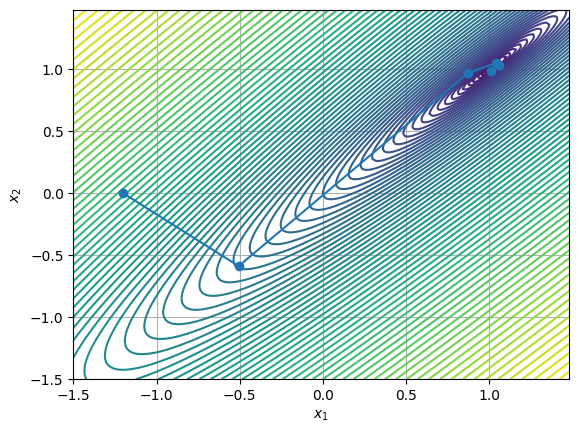

In [2043]:
e  = 0.01

x = modified_partan_mns(x0, h, diff_scheme, sven_par, e, ek)
x1 = [el[0].item() for el in x]
x2 = [el[1].item() for el in x]
fig = plt.figure()
x = np.arange(-1.5, 1.5, 0.02)
y = np.arange(-1.5, 1.5, 0.02)
X, Y = np.meshgrid(x, y)
Z = (10 * (X - Y) ** 2 + (X - 1) ** 2) ** (1/4)
plt.contour(X, Y, Z, 100)
plt.plot(x1, x2, 'o-')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)

In [2045]:
for criterion in [1, 2]:
    x = optimal_mns(x0, h, diff_scheme, sven_par, e, ek, criterion=criterion)[-1]
    print(f"point: {x.tolist()}\nfunc: {f(x).item()}")
    print(f"Функція обраховувалась таку кількість разів: {str(f_calls)}\n")
    f_calls = 0

point: [[0.9737589375014025], [0.957666841606696]]
func: 0.23928042304599334
Функція обраховувалась таку кількість разів: 928

point: [[0.9868799240370101], [0.9677628236232323]]
func: 0.2487185274044159
Функція обраховувалась таку кількість разів: 100026



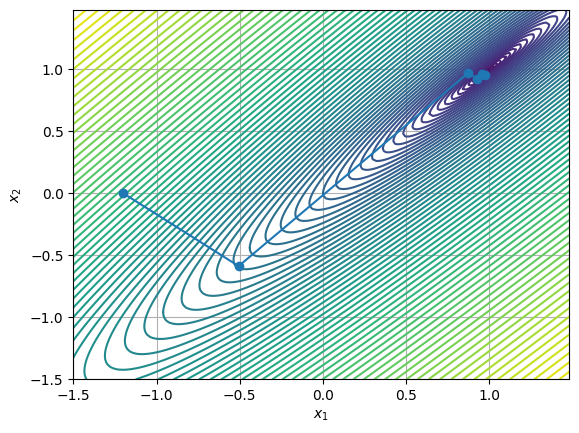

In [2044]:
x = optimal_mns(x0, h, diff_scheme, sven_par, e, ek)

x1 = [el[0].item() for el in x]
x2 = [el[1].item() for el in x]
fig = plt.figure()
x = np.arange(-1.5, 1.5, 0.02)
y = np.arange(-1.5, 1.5, 0.02)
X, Y = np.meshgrid(x, y)
Z = (10 * (X - Y) ** 2 + (X - 1) ** 2) ** (1/4)
plt.contour(X, Y, Z, 100)
plt.plot(x1, x2, 'o-')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)